In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import recall_score

In [122]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [123]:
#Описание датасета:

In [124]:
df = pd.read_csv('train_dataset_train.csv')
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


In [125]:
COLUMNS = df.columns

In [126]:
#Посмотрим, есть ли в данных пропуски:

In [127]:
for COLUMN in COLUMNS:
    print(f'Столбец: {COLUMN}, число пропусков:\t {df[COLUMN].isna().sum()}')

Столбец: id, число пропусков:	 0
Столбец: ticket_id, число пропусков:	 0
Столбец: ticket_type_nm, число пропусков:	 0
Столбец: entrance_id, число пропусков:	 0
Столбец: entrance_nm, число пропусков:	 0
Столбец: station_id, число пропусков:	 0
Столбец: station_nm, число пропусков:	 0
Столбец: line_id, число пропусков:	 0
Столбец: line_nm, число пропусков:	 0
Столбец: pass_dttm, число пропусков:	 0
Столбец: time_to_under, число пропусков:	 0
Столбец: label, число пропусков:	 0


In [128]:
#Отбросим не существенные для исследования столбцы таблицы: номер столбца, идентификационный номер билета,
#название станции метро и название линии метро

In [129]:
df = df.drop(['id', 'entrance_nm', 'station_nm', 'line_nm', 'ticket_id'], axis=1)
df

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
0,Пропуск FacePay,2402,11007,11,2022-09-12 05:00:13,216.316667,8001
1,СК учащегося 30 дней,110,2006,2,2022-09-12 05:00:54,648.183333,9011
2,БСК дружинника г.Москвы,110,2006,2,2022-09-12 05:00:55,865.333333,7022
3,30 дней,110,2006,2,2022-09-12 05:01:13,1048.233333,2022
4,КОШЕЛЕК,110,2006,2,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...,...
1091016,Пропуск FacePay,2283,15005,15,2022-09-19 02:54:50,124.750000,15005
1091017,Пропуск FacePay,278,6007,6,2022-09-19 03:06:02,56.066667,6007
1091018,Пропуск FacePay,118,2010,2,2022-09-19 03:17:00,91.283333,2010
1091019,Пропуск FacePay,2452,11014,11,2022-09-19 03:23:30,47.900000,11014


In [130]:
#Рассмотрим столбцы таблицы по отдельности. В столбце ticket_type_nm можно выделить категории пассажиров: рабочие, студенты, т.д.
#В столбце pass_dttm можно выделить дни и часы, чтобы выяснить и отсеять промежутки низкой активности метро. 

In [131]:
# 1. Рассмотрим столбец с типами билетов.

In [132]:
print(df.ticket_type_nm.unique())
print(len(df.ticket_type_nm.unique()))

['Пропуск FacePay' 'СК учащегося 30 дней' 'БСК дружинника г.Москвы'
 '30 дней' 'КОШЕЛЕК' 'СК студента 30 дней' '90 дней' '90 дней ЕДИНЫЙ ТК'
 '30 дней СК учащегося' '90 дней СК студента' '30 дней СК студента' 'ББК'
 'СК аспиранта 90 дней' 'Социальная карта москвича' '30 дней ЕДИНЫЙ ТК'
 'Социальная карта жителя Моск. области' '30 дней Пригород ТК'
 'Социальная карта москвича с сопровождающим'
 'Пропуск сотрудника УВД по охране Метрополитена' '60 поездок ЕДИНЫЙ ТК'
 'СК для сотрудника ГУВД г.Москвы' '365 дней ЕДИНЫЙ ТК'
 'ВЕСБ МОСКВА (7мин)' 'СК студента 90 дней' '90 дней Пригород ТК'
 '30 дней  Пригород' '365 дней Пригород ТК' '365 дней'
 'СК ординатора 30 дней' '30 дней СК аспиранта' '30 дней СК ординатора'
 '90 дней СК ординатора' 'ВЕСБ МО (7 мин)' 'ВЕСБ МО (тип 5)'
 'СК ординатора 90 дней' 'СК аспиранта 30 дней' '90 дней СК учащегося'
 'Временный билет ММ'
 'Социальная карта жителя Моск. области с сопровождающим'
 'СК учащегося 90 дней' '3 суток Единый ТК'
 'Пропуск сотрудника  метр

In [133]:
#Уникальных типов пропусков слишком много, поэтому разобьем их на группы так, что все члены одной из групп будут отнесены к одному типу:

In [134]:
StudentPass = ['СК студента 30 дней', 'СК учащегося 30 дней', '30 дней СК учащегося', '90 дней СК студента',
                '30 дней СК студента', 'СК ординатора 90 дней', 'СК аспиранта 90 дней', 'СК учащегося 90 дней',
                'СК аспиранта 30 дней', '90 дней СК учащегося', 'СК ординатора 30 дней', '30 дней СК аспиранта',
                '30 дней СК ординатора', '90 дней СК ординатора', 'СК студента 90 дней', '90 дней СК аспиранта']
SubwayWorkerPass = ['Пропуск сотрудника УВД по охране Метрополитена', 'Пропуск сотрудника МЦК','Пропуск руководителя метрополитена',
                    'Пропуск сотрудника метрополитена', 'СК ассистента-стажера 30 дней', 'СК ассистента-стажера 90 дней',
                    '30 дней СК ассистента-стажера', 'Пропуск  сотрудника МЦК', 'Пропуск сотрудника  метрополитена']
SocialPass = ['Социальная карта жителя Моск. области с сопровождающим', 'Социальная карта жителя Моск. области', 
              'Социальная карта москвича с сопровождающим', 'Социальная карта москвича', 'БСК дружинника г.Москвы', 
              'СК для сотрудника ГУВД г.Москвы', 'ВЛБ МОСКВА', 'ВЕСБ МО с сопровождающим', 'ВЕСБ МОСКВА (7мин)', 
              'ВЕСБ МО (тип 5)', 'ВЕСБ МО (тип 6)', 'ВЕСБ МОСКВА', 'ВЕСБ МО (7 мин)', 'Временный билет ММ']
SuburbianPass = ['1 сутки Пригород ТК', '90 дней Пригород', '365 дней Пригород', '30 дней Пригород', '90 дней Пригород ТК',
                '30 дней Пригород ТК', '365 дней Пригород ТК', 'ББК', '30 дней  Пригород', '90 дней  Пригород', '365 дней  Пригород']
MoneyPass = ['Пропуск FacePay', 'КОШЕЛЕК', 'Безналичная транспортная карта']
OtherPass = ['30 дней', '90 дней', '30 дней ЕДИНЫЙ ТК', '60 поездок ЕДИНЫЙ ТК', '365 дней ЕДИНЫЙ ТК' , '365 дней', '3 суток Единый ТК',
             '1 сутки ЕДИНЫЙ ТК', 'Ультралайт Единый (70)', 'Билет 3 суток ЕДИНЫЙ', 'Билет 3 суток ЕДИНЫЙ', '90 дней ЕДИНЫЙ ТК',
             'Билет 1 сутки ЕДИНЫЙ']

In [135]:
#Заменим первичные ticket_type_nm на новые в соответствии с их наличием в соответствующей группе наименований:

In [136]:
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(SubwayWorkerPass), 'SubwayWorkerPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(MoneyPass), 'MoneyPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(StudentPass), 'StudentPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(SuburbianPass), 'SuburbianPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(SocialPass), 'SocialPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(OtherPass), 'OtherPass', inplace=True)

In [137]:
df

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
0,MoneyPass,2402,11007,11,2022-09-12 05:00:13,216.316667,8001
1,StudentPass,110,2006,2,2022-09-12 05:00:54,648.183333,9011
2,SocialPass,110,2006,2,2022-09-12 05:00:55,865.333333,7022
3,OtherPass,110,2006,2,2022-09-12 05:01:13,1048.233333,2022
4,MoneyPass,110,2006,2,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...,...
1091016,MoneyPass,2283,15005,15,2022-09-19 02:54:50,124.750000,15005
1091017,MoneyPass,278,6007,6,2022-09-19 03:06:02,56.066667,6007
1091018,MoneyPass,118,2010,2,2022-09-19 03:17:00,91.283333,2010
1091019,MoneyPass,2452,11014,11,2022-09-19 03:23:30,47.900000,11014


In [138]:
#Количество признаков столбца ticket_type_nm уменьшилось с 60 до 6

In [139]:
#Далее рассмотрим дату и время.
#Разделим столбец pass_dttm на часы и дни. 

In [140]:
df["pass_dttm"] = pd.to_datetime(df["pass_dttm"])
df_tmp = df["pass_dttm"].dt.hour
df_tmp = df_tmp.value_counts()
df_tmp = df_tmp.reset_index().rename(columns = {'index': 'hour', 'pass_dttm': 'number_of_people'})
df_tmp

,hour,number_of_people
0,8,232006
1,7,208545
2,9,141080
3,6,116616
4,10,77730
5,11,54940
6,12,42521
7,13,38645
8,14,32010
9,15,28072


In [141]:
#Построим гистограмму.

<AxesSubplot:xlabel='hour', ylabel='number_of_people'>

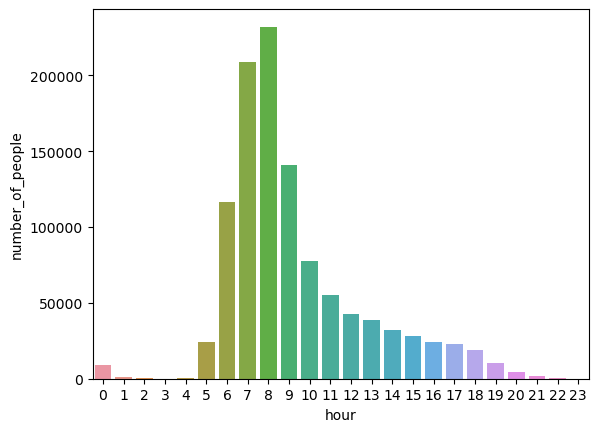

In [142]:
sns.barplot(x = df_tmp["hour"], y = df_tmp["number_of_people"])

In [143]:
#Аналогично поступим с днями недели:

In [144]:
df_tmp2 = df["pass_dttm"].dt.weekday
df_tmp2 = df_tmp2.value_counts()
df_tmp2 = df_tmp2.reset_index().rename(columns = {'index': 'day', 'pass_dttm': 'number_of_people'})
df_tmp2

,day,number_of_people
0,0,169081
1,1,169068
2,2,168584
3,3,166645
4,4,160868
5,5,136813
6,6,119962


<AxesSubplot:xlabel='day', ylabel='number_of_people'>

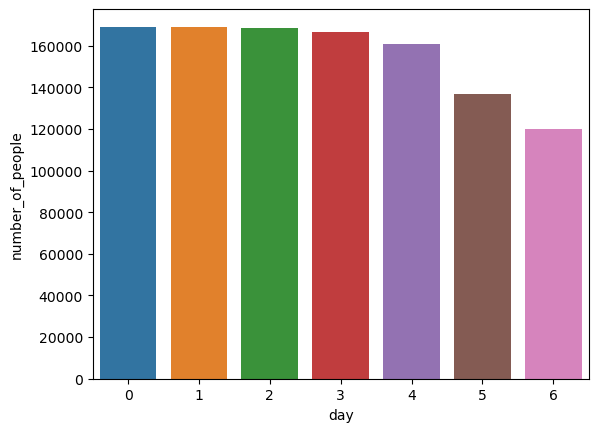

In [145]:
sns.barplot(x = df_tmp2["day"], y = df_tmp2["number_of_people"])

In [146]:
df.pass_dttm = pd.to_datetime(df.pass_dttm)
df['dayOfWeek'] = df.pass_dttm.dt.weekday
df['hour'] = df.pass_dttm.dt.hour
df.drop(['pass_dttm'], axis=1)

,ticket_type_nm,entrance_id,station_id,line_id,time_to_under,label,dayOfWeek,hour
0,MoneyPass,2402,11007,11,216.316667,8001,0,5
1,StudentPass,110,2006,2,648.183333,9011,0,5
2,SocialPass,110,2006,2,865.333333,7022,0,5
3,OtherPass,110,2006,2,1048.233333,2022,0,5
4,MoneyPass,110,2006,2,965.600000,2017,0,5
...,...,...,...,...,...,...,...,...
1091016,MoneyPass,2283,15005,15,124.750000,15005,0,2
1091017,MoneyPass,278,6007,6,56.066667,6007,0,3
1091018,MoneyPass,118,2010,2,91.283333,2010,0,3
1091019,MoneyPass,2452,11014,11,47.900000,11014,0,3


In [147]:
#сосредоточимся на рассмотрении только пиковых часов:

In [148]:
rushHour = [5, 6, 7, 8, 9, 10]
df['isRushHour'] = False
df['isRushHour'].mask(df.hour.isin(rushHour), True, inplace=True)

weekend = [5, 6]
df['isWeekend'] = False
df['isWeekend'].mask(df.dayOfWeek.isin(weekend), True, inplace=True)

df = df.drop(['pass_dttm'], axis=1)

In [149]:
df

,ticket_type_nm,entrance_id,station_id,line_id,time_to_under,label,dayOfWeek,hour,isRushHour,isWeekend
0,MoneyPass,2402,11007,11,216.316667,8001,0,5,True,False
1,StudentPass,110,2006,2,648.183333,9011,0,5,True,False
2,SocialPass,110,2006,2,865.333333,7022,0,5,True,False
3,OtherPass,110,2006,2,1048.233333,2022,0,5,True,False
4,MoneyPass,110,2006,2,965.600000,2017,0,5,True,False
...,...,...,...,...,...,...,...,...,...,...
1091016,MoneyPass,2283,15005,15,124.750000,15005,0,2,False,False
1091017,MoneyPass,278,6007,6,56.066667,6007,0,3,False,False
1091018,MoneyPass,118,2010,2,91.283333,2010,0,3,False,False
1091019,MoneyPass,2452,11014,11,47.900000,11014,0,3,False,False


In [150]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
data_ttype = onehotencoder.fit_transform(df[['ticket_type_nm']])
data_ttype = pd.DataFrame(data_ttype.toarray(), columns=onehotencoder.categories_[0])
data_new = pd.concat([df, data_ttype], axis=1)
data_new = data_new.drop('ticket_type_nm', axis=1)
data_new

,entrance_id,station_id,line_id,time_to_under,label,dayOfWeek,hour,isRushHour,isWeekend,MoneyPass,OtherPass,SocialPass,StudentPass,SuburbianPass,SubwayWorkerPass
0,2402,11007,11,216.316667,8001,0,5,True,False,1.0,0.0,0.0,0.0,0.0,0.0
1,110,2006,2,648.183333,9011,0,5,True,False,0.0,0.0,0.0,1.0,0.0,0.0
2,110,2006,2,865.333333,7022,0,5,True,False,0.0,0.0,1.0,0.0,0.0,0.0
3,110,2006,2,1048.233333,2022,0,5,True,False,0.0,1.0,0.0,0.0,0.0,0.0
4,110,2006,2,965.600000,2017,0,5,True,False,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,2283,15005,15,124.750000,15005,0,2,False,False,1.0,0.0,0.0,0.0,0.0,0.0
1091017,278,6007,6,56.066667,6007,0,3,False,False,1.0,0.0,0.0,0.0,0.0,0.0
1091018,118,2010,2,91.283333,2010,0,3,False,False,1.0,0.0,0.0,0.0,0.0,0.0
1091019,2452,11014,11,47.900000,11014,0,3,False,False,1.0,0.0,0.0,0.0,0.0,0.0


In [151]:
col_type = data_new.columns.to_list()
print(col_type)

['entrance_id', 'station_id', 'line_id', 'time_to_under', 'label', 'dayOfWeek', 'hour', 'isRushHour', 'isWeekend', 'MoneyPass', 'OtherPass', 'SocialPass', 'StudentPass', 'SuburbianPass', 'SubwayWorkerPass']


In [152]:
columns_set_1 = ['entrance_id', 'station_id', 'line_id', 'hour','isRushHour', 'isWeekend', 'MoneyPass',
                 'OtherPass', 'SocialPass', 'StudentPass', 'SuburbianPass', 'SubwayWorkerPass']

In [153]:
#Модель:

In [154]:
X = data_new[columns_set_1]
Y = y = data_new['time_to_under']

In [155]:
#почему test_size = 0.2????????????????????????????????????????????????????

In [156]:
x_regress_train, x_regress_test, y_regress_train, y_regress_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#разделение на тестовые и тренировочные выборки

In [157]:
#Рандомный лес

In [158]:
from sklearn.ensemble import RandomForestRegressor


In [159]:
rf = RandomForestRegressor()

In [181]:
rf.fit(x_regress_train, y_regress_train)
#поставил обучаться модель на тренировочной выборке

RandomForestRegressor()

In [161]:
y_pred_rf = rf.predict(x_regress_test)
r2_score(y_regress_test, y_pred_rf)
#подсчет метрики R2

0.5029867856316687

In [163]:
#XBOOST
import xgboost as xgb
model_xgb = xgb.XGBRegressor()
model_xgb.fit(x_regress_train, y_regress_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [164]:
y_pred_xgb = model_xgb.predict(x_regress_test)
r2_score(y_regress_test, y_pred_xgb)

0.5229200482600851

In [165]:
#CATBOOST
cat = CatBoostRegressor()
cat.fit(x_regress_train, y_regress_train)

Learning rate set to 0.119356
0:	learn: 219.6312316	total: 100ms	remaining: 1m 40s
1:	learn: 208.6746331	total: 188ms	remaining: 1m 33s
2:	learn: 199.7887495	total: 260ms	remaining: 1m 26s
3:	learn: 192.5638976	total: 329ms	remaining: 1m 22s
4:	learn: 186.6621403	total: 405ms	remaining: 1m 20s
5:	learn: 181.8733078	total: 474ms	remaining: 1m 18s
6:	learn: 178.1122601	total: 542ms	remaining: 1m 16s
7:	learn: 174.9503185	total: 617ms	remaining: 1m 16s
8:	learn: 172.4476980	total: 687ms	remaining: 1m 15s
9:	learn: 170.4416522	total: 754ms	remaining: 1m 14s
10:	learn: 168.8510640	total: 826ms	remaining: 1m 14s
11:	learn: 167.5222388	total: 894ms	remaining: 1m 13s
12:	learn: 166.4907103	total: 959ms	remaining: 1m 12s
13:	learn: 165.6527379	total: 1.03s	remaining: 1m 12s
14:	learn: 164.9976476	total: 1.1s	remaining: 1m 12s
15:	learn: 164.4626161	total: 1.16s	remaining: 1m 11s
16:	learn: 163.9954003	total: 1.24s	remaining: 1m 11s
17:	learn: 163.6480828	total: 1.3s	remaining: 1m 11s
18:	learn:

In [166]:
y_pred_cat = cat.predict(x_regress_test)
r2_score(y_regress_test, y_pred_cat)

0.5229447392363779

In [167]:
#ЛИНЕЙНАЯ РЕГРЕССИЯ
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(x_regress_train, y_regress_train)

LinearRegression()

In [182]:
y_pred_lr = model_lr.predict(x_regress_test)
r2_score(y_regress_test, y_pred_lr)

0.4974025087631816

КЛАССИФИКАЦИЯ

In [171]:
data_new1 = data_new.iloc[:50000]
columns_set_1 = ['entrance_id', 'station_id', 'line_id', 'hour','isRushHour', 'isWeekend', 'MoneyPass',
                 'OtherPass', 'SocialPass', 'StudentPass', 'SuburbianPass', 'SubwayWorkerPass']
X = data_new1[columns_set_1]
y = data_new1['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [173]:
clf_tree = DecisionTreeClassifier()


In [174]:
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)

In [175]:
recall_score(y_test, y_pred, average='weighted')

0.0648

In [176]:
encoder = LabelEncoder()
encoder.fit(data_new1['label'])

LabelEncoder()

In [177]:
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)

In [178]:
model_xgb = xgb.XGBClassifier(subsample=0.2, n_estimators=50)
model_xgb.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [179]:
y_pred_xgb = model_xgb.predict(X_test)
recall_score(y_test_enc, y_pred_xgb, average='weighted')

0.06873333333333333

In [180]:
print(0.06873333333333333*0.5+0.5229447392363779*0.5)

0.2958390362848556
